### This class forms the core of a minimal autograd system from scratch, allowing you to train neural networks without external libraries like PyTorch or TensorFlow.


In [144]:
import math

class Value: 
  def __init__(self, value, inputs=[], operation=''):
    self.value = value # actual numbers 
    self.inputs = inputs # the previous node
    self.operation = operation # for graph tracing/visualization.
    self.grad = 0.0 
    self._backprop = lambda: None

  def relu(self):
    result = Value(max(0, self.value), inputs=(self,), operation='relu') # if the value < 0 the output is 0, otherwise its the value itself
    def _backprop():
      self.grad += result.grad * (result.value > 0) 
    result._backprop = _backprop
    return result

  def sigmoid(self):
    sig = 1 / (1 + math.exp(-self.value))
    result = Value(sig, inputs=(self,), operation='sigmoid')
    def _backprop():
      self.grad += result.grad * (sig * (1 - sig))
    result._backprop = _backprop
    return result
    
  def log(self): # the derivative of log(x) is 1/x
    result = Value(math.log(self.value), inputs=(self,), operation='log')
    def _backprop():
      self.grad += result.grad * (1 / self.value) # dy/dx = 1/x
    result._backprop = _backprop
    return result

  def __repr__(self):
    return f"Value: {self.value}, Grad: {self.grad}"

  def __radd__(self, other):
    return self + other

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    result = Value(self.value + other.value, inputs=(self, other), operation='+')
    def _backprop():
      self.grad += result.grad
      other.grad += result.grad
    result._backprop = _backprop
    return result

  def __rmul__(self, other):
    return self * other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    result = Value(self.value * other.value, inputs=(self, other), operation='*')
    def _backprop():
      self.grad += result.grad * other.value # dz/dx = y
      other.grad += result.grad * self.value # dz/dy = x
    result._backprop = _backprop
    return result

  def __truediv__(self, other):
    return self * (other) ** -1

  def __pow__(self, other):
    result = Value(self.value ** other, inputs=[self], operation=f'^{other}')
    def _backprop():
      self.grad += result.grad * (other * (self.value ** (other - 1))) # dz/dx = n * x^n-1
    result._backprop = _backprop
    return result

  def __sub__(self, other):
    return self + (-other)

  def __neg__(self):
    result = Value(-self.value, inputs=(self,), operation='neg')
    def _backprop():
        self.grad += -result.grad  # d(-x)/dx = -1
    result._backprop = _backprop
    return result

  def backprop(self):
    topo = [] # to hold the order of computation
    visited = set() # to keep track the nodes we have visited
    def build(node):
      if node not in visited:
        visited.add(node)
        for input_node in node.inputs:
          build(input_node)
        topo.append(node)
    build(self)
    for node in reversed(topo):
      node._backprop()


### Computational Graph Visualization

In [145]:
# for graph visualization
from graphviz import Digraph
def trace(root):
    nodes = set()
    edges = []
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for parent in v.inputs:    
                edges.append((parent, v))
                build(parent)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f"{n.operation} | value={n.value:.4f} | grad={n.grad:.4f}", shape='record')  # changed op->operation, data->value
        if n.operation:
            dot.node(name=uid+n.operation, label=n.operation)
            dot.edge(uid+n.operation, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.operation)

    return dot


### Example 

Value: 100, Grad: 0.0


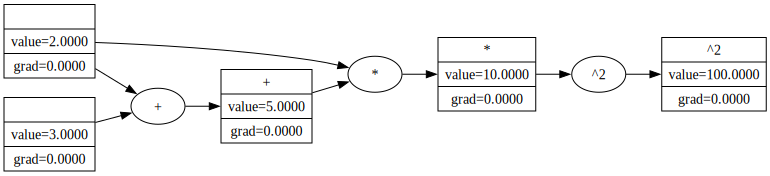

In [146]:
# lets take a simple example
x = Value(2)
y = Value(3)
z = x + y # 2 + 3 = 5
w = z * x # 5 * 2 = 10
l = w ** 2 # 10^2 = 100

print(l)
draw_dot(l)

### How we do a Backward Pass
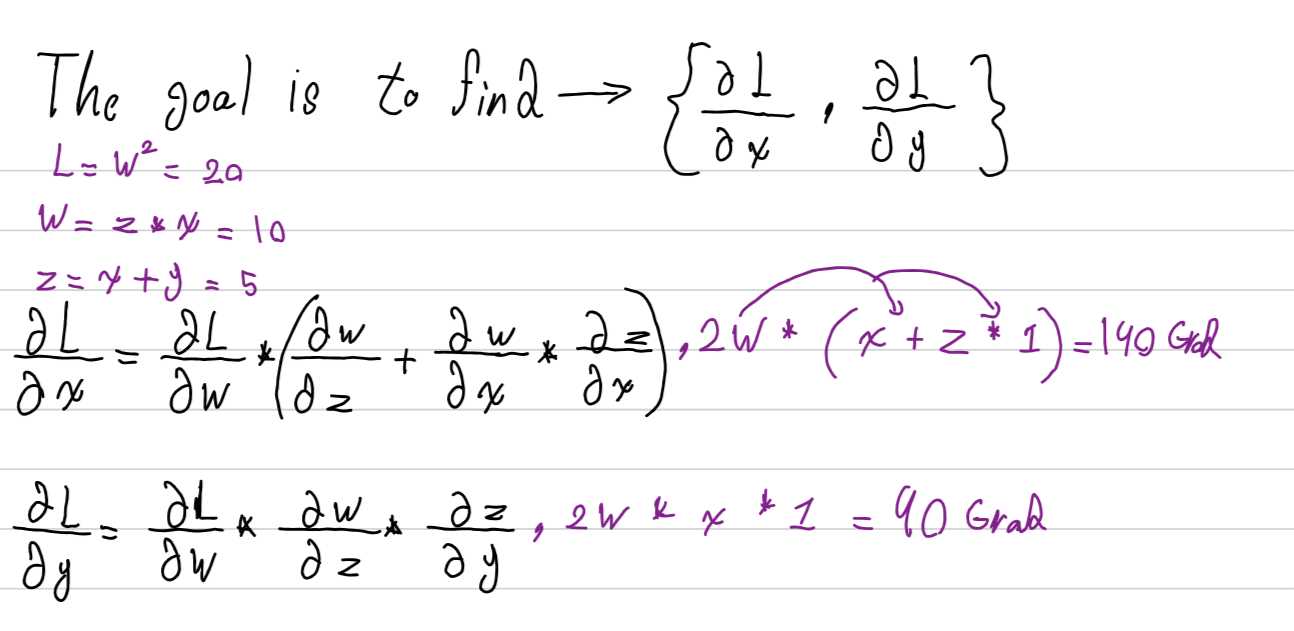

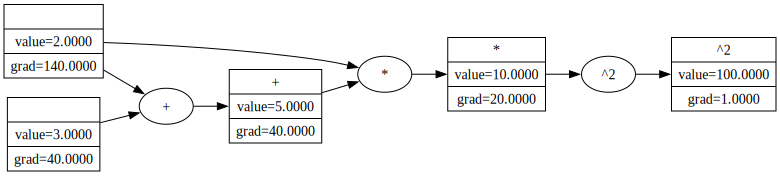

In [147]:
l.grad = 1
l.backprop()
draw_dot(l)

### Neuron, Layer, and MLP

In [148]:
import random
import math

class Neuron:
    def __init__(self, num_inputs, activation=''):
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(num_inputs)] # Initialize random weights
        self.bias = Value(random.uniform(-1, 1)) # also a random bias 
        self.activation = activation

    def __call__(self, input_values):
        weighted_sum = sum(weight * inp for weight, inp in zip(self.weights, input_values)) # compute the weighted sum 
        output = weighted_sum + self.bias
        if self.activation == 'relu':
            output = output.relu()
        return output

    def parameters(self): # return the trainable parameters 
        return self.weights + [self.bias]

    def __repr__(self):
        return f"Neuron(num_inputs={len(self.weights)}, activation={self.activation})"


class Layer:
    def __init__(self, input_size, output_size):
        self.neurons = []
        for i in range(output_size - 1):
            self.neurons.append(Neuron(input_size, activation='relu'))
        self.neurons.append(Neuron(input_size, activation=''))  # Last neuron has no activation

    def __call__(self, inputs):
        outputs = [neuron(inputs) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]

    def __repr__(self):
        return f"Layer(num_neurons={len(self.neurons)})"


class MLP:
    def __init__(self, layer_sizes):
        self.layers = [Layer(layer_sizes[i - 1], layer_sizes[i]) for i in range(1, len(layer_sizes))]

    def __call__(self, inputs):
        for layer in self.layers:
            inputs = layer(inputs)
        return inputs

    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

    def __repr__(self):
        return f"MLP(num_layers={len(self.layers)})"


# 

## Testing the Model 

### Importing Libraries and Modules

In [149]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import seaborn as sns
import pandas as pd


### Loading the Iris Dataset

In [150]:
iris = load_iris()
X = iris.data        # shape (150, 4)
y = iris.target      # shape (150,)

print("Features:", iris.feature_names)
print("Classes:", iris.target_names)
print("X shape:", X.shape, "y shape:", y.shape)


Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']
X shape: (150, 4) y shape: (150,)


### EDA

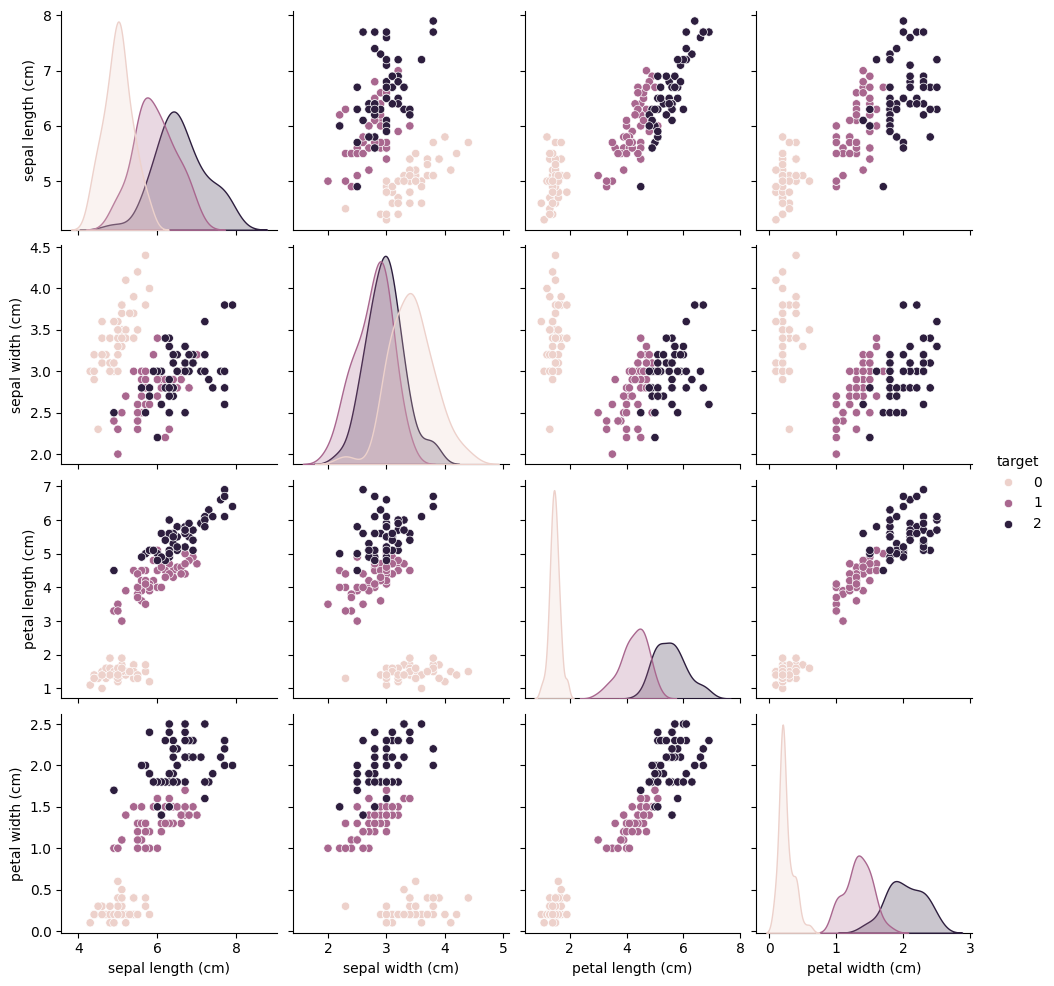

In [151]:

df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y
sns.pairplot(df, hue='target')
plt.show()


### Data Preprocessing and Train-Test Split

In [152]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)


### Training and Testing Functions 

In [153]:
def train_mlp(model, X_train, y_train, epochs=100, lr=0.01):
    history = {'loss': [], 'accuracy': []}

    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0

        for xi, yi in zip(X_train, y_train):
            inputs = [Value(v) for v in xi]
            targets = [Value(t) for t in yi]

            outputs = model(inputs)
            if not isinstance(outputs, list):
                outputs = [outputs]

            # MSE loss
            loss = sum((o - t) ** 2 for o, t in zip(outputs, targets))
            total_loss += loss.value

            # Backprop
            for p in model.parameters():
                p.grad = 0.0
            loss.grad = 1.0
            loss.backprop()

            # Gradient descent step
            for p in model.parameters():
                p.value -= lr * p.grad

            # Accuracy
            pred = np.argmax([o.value for o in outputs])
            actual = np.argmax([t.value for t in targets])
            if pred == actual:
                correct += 1

        avg_loss = total_loss / len(X_train)
        accuracy = correct / len(X_train)

        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} — Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return history

In [154]:
def evaluate_mlp(model, X_test, y_test):
    total_loss = 0.0
    correct = 0

    for xi, yi in zip(X_test, y_test):
        inputs = [Value(v) for v in xi]
        targets = [Value(t) for t in yi]

        outputs = model(inputs)
        if not isinstance(outputs, list):
            outputs = [outputs]

        loss = sum((o - t) ** 2 for o, t in zip(outputs, targets))
        total_loss += loss.value

        pred = np.argmax([o.value for o in outputs])
        actual = np.argmax([t.value for t in targets])
        if pred == actual:
            correct += 1

    avg_loss = total_loss / len(X_test)
    accuracy = correct / len(X_test)

    print(f"✅ Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


### Plotting the Results 

In [155]:
def plot_training(history):
    epochs = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['loss'], label='Loss', color='red')
    plt.plot(epochs, history['accuracy'], label='Accuracy', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.title('Training Loss & Accuracy')
    plt.legend()
    plt.show()

Epoch 1/100 — Loss: 1.0755, Accuracy: 0.4583
Epoch 10/100 — Loss: 0.0973, Accuracy: 0.9750
Epoch 20/100 — Loss: 0.0659, Accuracy: 0.9750
Epoch 30/100 — Loss: 0.0608, Accuracy: 0.9750
Epoch 40/100 — Loss: 0.0571, Accuracy: 0.9750
Epoch 50/100 — Loss: 0.0558, Accuracy: 0.9833
Epoch 60/100 — Loss: 0.0551, Accuracy: 0.9833
Epoch 70/100 — Loss: 0.0547, Accuracy: 0.9833
Epoch 80/100 — Loss: 0.0544, Accuracy: 0.9833
Epoch 90/100 — Loss: 0.0540, Accuracy: 0.9833
Epoch 100/100 — Loss: 0.0537, Accuracy: 0.9833
✅ Test Loss: 0.0771, Test Accuracy: 1.0000


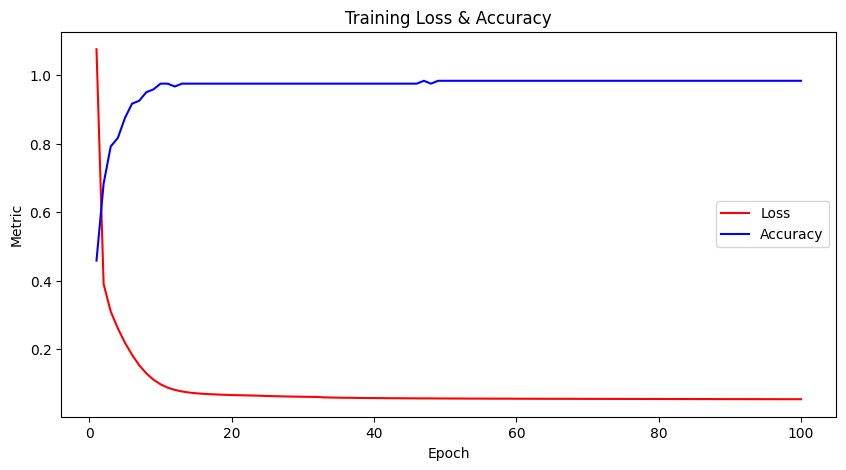

In [156]:
mlp_model = MLP([4, 8, 3])

history = train_mlp(mlp_model, X_train, y_train, epochs=100, lr=0.01)

test_loss, test_acc = evaluate_mlp(mlp_model, X_test, y_test)

plot_training(history)
